## Trace Analysis of SAT data

In [104]:
#to suppress seaborn palette warnings
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

import pandas as pd
import seaborn as sns

import loader
import analysis_functions

pd.options.mode.chained_assignment = None  # default='warn'

#### Load and Format Data

In [105]:
default_acc = 1

#load metadata - replace with local paths to metadata files
path_metadata = "C:\\Users\\swind\\Documents\\lab_work\\Barth\\behavior_analysis\\Eunsol_data\\Animal lists.xlsx"
path_metasat = "C:\\Users\\swind\\Documents\\lab_work\\Barth\\behavior_analysis\\Eunsol_data\\behavior metasheet.xlsx"
sat_metadata = pd.read_excel(path_metasat)
hm4di_metadata = pd.read_excel(path_metadata)

#load data - replace with local paths to text files
SAT_path = "C:\\Users\\swind\\Documents\\lab_work\\Barth\\behavior_analysis\\Eunsol_data\\all_animals\\SAT"
all_reward_path = "C:\\Users\\swind\\Documents\\lab_work\\Barth\\behavior_analysis\\Eunsol_data\\all_animals\\all_reward"
mcherry_path = "C:\\Users\\swind\\Documents\\lab_work\\Barth\\behavior_analysis\\Eunsol_data\\all_animals\\mcherry"
hm4di_path = "C:\\Users\\swind\\Documents\\lab_work\\Barth\\behavior_analysis\\Eunsol_data\\all_animals\\hm4di"

sat = loader.make_condition_df(SAT_path, "SAT", sat_metadata, "ACC days", default_acc)
all_reward = loader.make_condition_df(all_reward_path, "all_reward", sat_metadata, "ACC days", default_acc)
mcherry = loader.make_condition_df(mcherry_path, "mcherry", hm4di_metadata, "Acclimation (days)", default_acc)
hm4di = loader.make_condition_df(hm4di_path, "hm4di", hm4di_metadata, "Acclimation (days)", default_acc)

all_animals = pd.concat([sat, all_reward, mcherry, hm4di])

NKZ4: no metadata
NLB1: no metadata


### Analysis

In [133]:
# do not modify loaded data
aa = all_animals.copy()

# exlcude an animal that did not learn from the analysis
aa = aa[(aa["animal"] != "JOV1")]

In [134]:
# calculated time to air puff
index = ["condition", "animal","trial no"]
data = analysis_functions.puff_delta(aa, index)

In [135]:
# rolling window average licking frequency
# TODO: (moderately) slow (26s on 4 conditions, 10+ animals per condition)
freq_bin = 300
keep = ["timestamp", "age", "sex", "strain", "acc", "delivery delta"]
values = ["lick", "poke"]
index = ["condition", "animal", "trial no", "trial type"]

data = analysis_functions.rolling_frequency_average(data, freq_bin, values, keep, index)

In [136]:
# resampling for trial alignment
keep = ["timestamp", "lick", "poke", "age", "sex", "strain", "acc"]
index = ["condition", "animal", "trial no", "trial type"]

data = analysis_functions.resample_align(data, 100, "delivery delta", keep, index)

In [137]:
#label start of trial at each sample
index = ["condition", "animal", "trial no"]

data = analysis_functions.get_trial_start(data, index, "timestamp")

In [138]:
#bin by time (4h bins)
index = ["condition", "animal", "trial no", "trial type", "delivery delta"]
data_4h = analysis_functions.bin_by_time(data, 4, "h", index, "trial time")

#1h bins
data_1h = analysis_functions.bin_by_time(data, 1, "h", index, "trial time")

In [140]:
# calulate time bin relative to start of SAT training
index = ["condition", "animal", "trial no"]

data_4h = analysis_functions.delta(data_4h, index, "trial time")
data_1h = analysis_functions.delta(data_1h, index, "trial time")

In [142]:
# drop bins with fewer than 10 total trials, or with no trials of one kind
min_trials = 10
min_blank = 1
min_water = 1
index = ["condition", "animal", "delta","delivery delta"]
key = "trial type"

data_4h = analysis_functions.drop_bins(data_4h, min_trials, min_blank, min_water, index, key)
data_1h = analysis_functions.drop_bins(data_1h, min_trials, min_blank, min_water, index, key)

In [144]:
#convert time bins and trial time to float representations
data_4h["Time (hr)"] = data_4h["delta"].to_numpy(dtype="timedelta64[h]").astype("float")
data_4h["Time (ms)"] = data_4h["delivery delta"].to_numpy(dtype="timedelta64[ms]").astype("float")

data_1h["Time (hr)"] = data_1h["delta"].to_numpy(dtype="timedelta64[h]").astype("float")
data_1h["Time (ms)"] = data_1h["delivery delta"].to_numpy(dtype="timedelta64[ms]").astype("float")

In [145]:
# number of trials for each timebin
index = ["condition", "animal", "delta", "delivery delta"]
keep = ["age", "sex", "strain", "acc", "Time (hr)", "Time (ms)"]
counts_4h = analysis_functions.trial_counts(data_4h, index, keep, "trial no")
counts_1h = analysis_functions.trial_counts(data_1h, index, keep, "trial no")

In [156]:
# mean licking frequencys for each animals for each time bin 
keep = ["age", "sex", "strain", "acc","Time (hr)", "Time (ms)"]
index = ["condition", "animal", "trial type", "delta", "delivery delta"]
value = ["lick"]

data_4h = analysis_functions.mean_bin(data_4h, index, value, keep)
data_1h = analysis_functions.mean_bin(data_1h, index, value, keep)

In [157]:
#threshold trials to 200ms before to 2000ms after air puff
data_4h = analysis_functions.thresh(data_4h, -200, 2000)
data_1h = analysis_functions.thresh(data_1h, -200, 2000)

In [118]:
#calculate performance for each animal for each time bin
index = ["condition", "animal", "delta", "delivery delta"]
keep = ["age", "sex", "strain", "Time (hr)", "Time (ms)"]
perf_4h = analysis_functions.performance(data_4h, index, keep)
perf_1h = analysis_functions.performance(data_1h, index, keep)

### Plotting

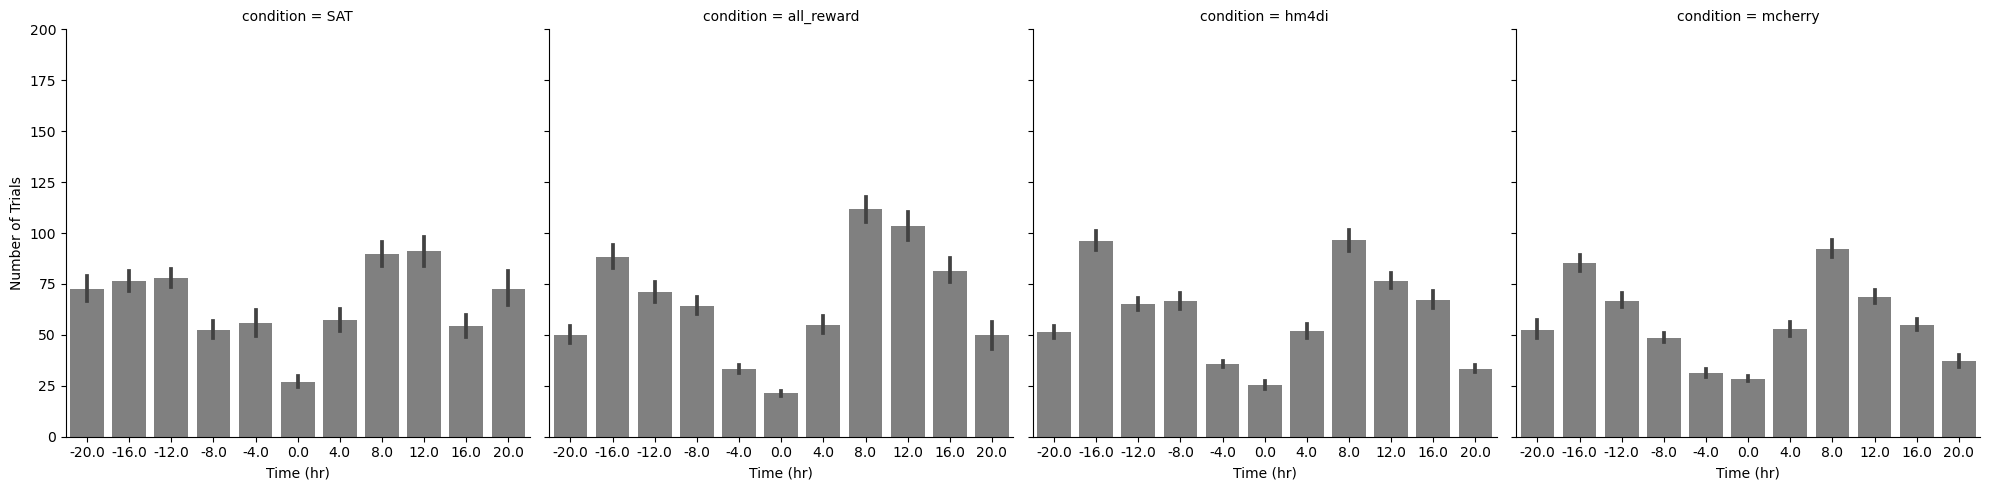

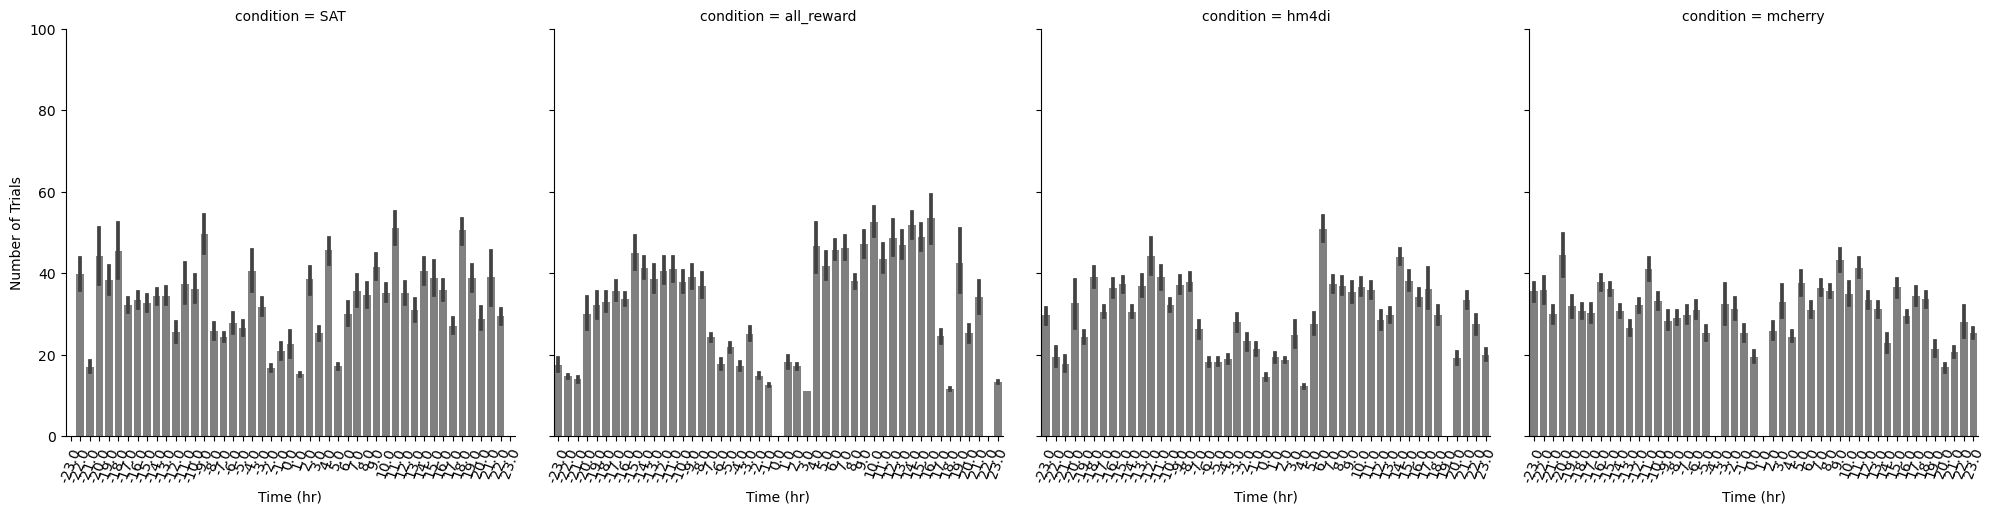

In [119]:
cond = (counts_4h["Time (hr)"] < 24) & (counts_4h["Time (hr)"] > -24) 
g = sns.catplot(counts_4h[cond], x="Time (hr)", y="trial no", col="condition", kind='bar', color="grey")
for ax in g.axes.flat:
    ax.set_ylabel("Number of Trials")
    ax.set_ylim([0, 200])

cond = (counts_1h["Time (hr)"] < 24) & (counts_1h["Time (hr)"] > -24) 
g = sns.catplot(counts_1h[cond], x="Time (hr)", y="trial no", col="condition", kind='bar', color="grey")
for ax in g.axes.flat:
    ax.set_xticklabels(ax.get_xticklabels(), rotation=70, ha='center')
    ax.set_ylabel("Number of Trials")
    ax.set_ylim([0, 100])

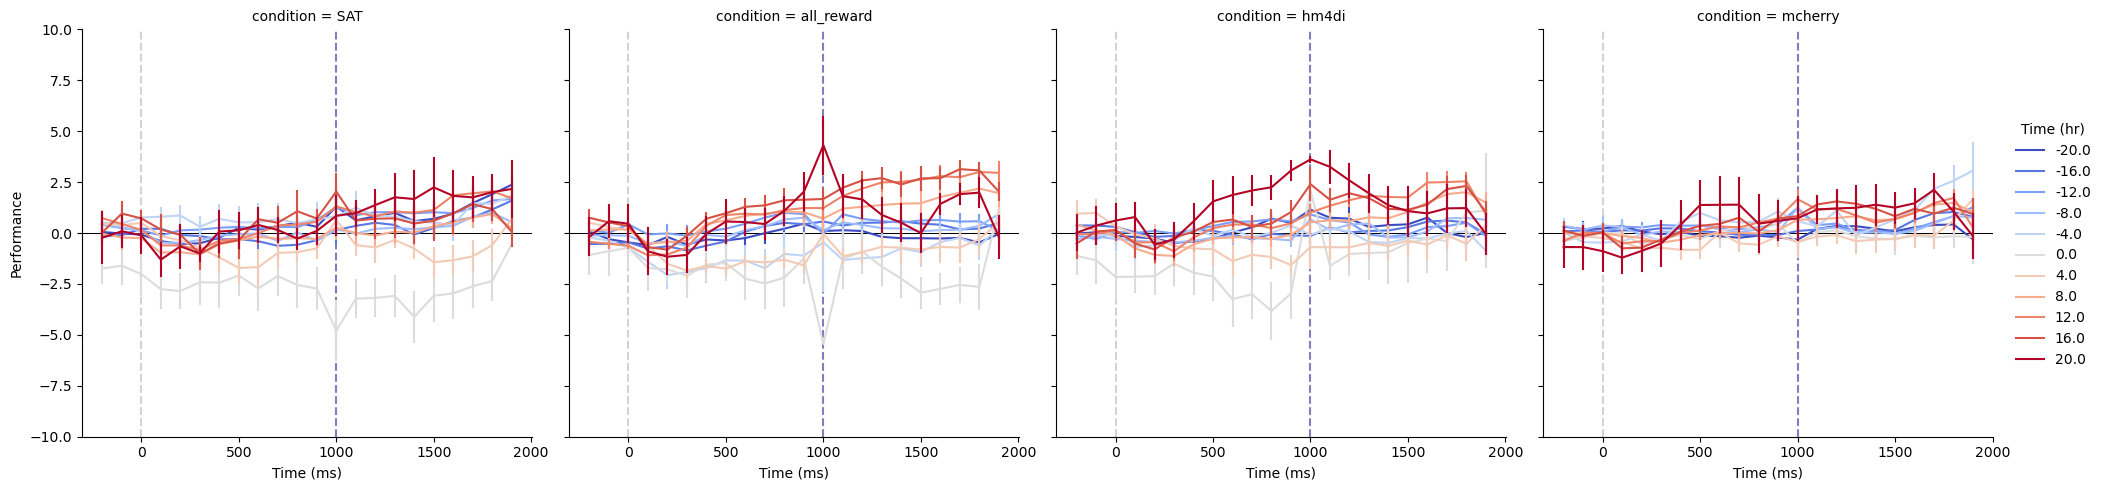

In [120]:
# average performance trace across all timebins, 4h

# only plot last day of acclimation and first day of SAT
cond = (perf_4h["Time (hr)"] < 24) & (perf_4h["Time (hr)"] > -24)

# plot all timebins average performance trace on the same plot
g = sns.relplot(data=perf_4h[cond],kind="line",x="Time (ms)", y="lick",col="condition", 
                hue="Time (hr)", palette="coolwarm", errorbar="se",err_style="bars", legend="full")

# add lines at air puff and water delivery
for ax in g.axes.flat:
    ax.axhline(y=0, xmin=0, xmax=1, ls="-", lw=0.75,color="black", zorder=0)
    ax.axvline(x=0, ymin=0, ymax=1, ls="--", color="lightgrey", zorder=0)
    ax.axvline(x=1000, ymin=0, ymax=1, ls="--", color="navy", alpha=0.5, zorder=0)
    ax.set_ylim([-10, 10])
    ax.set_ylabel("Performance")

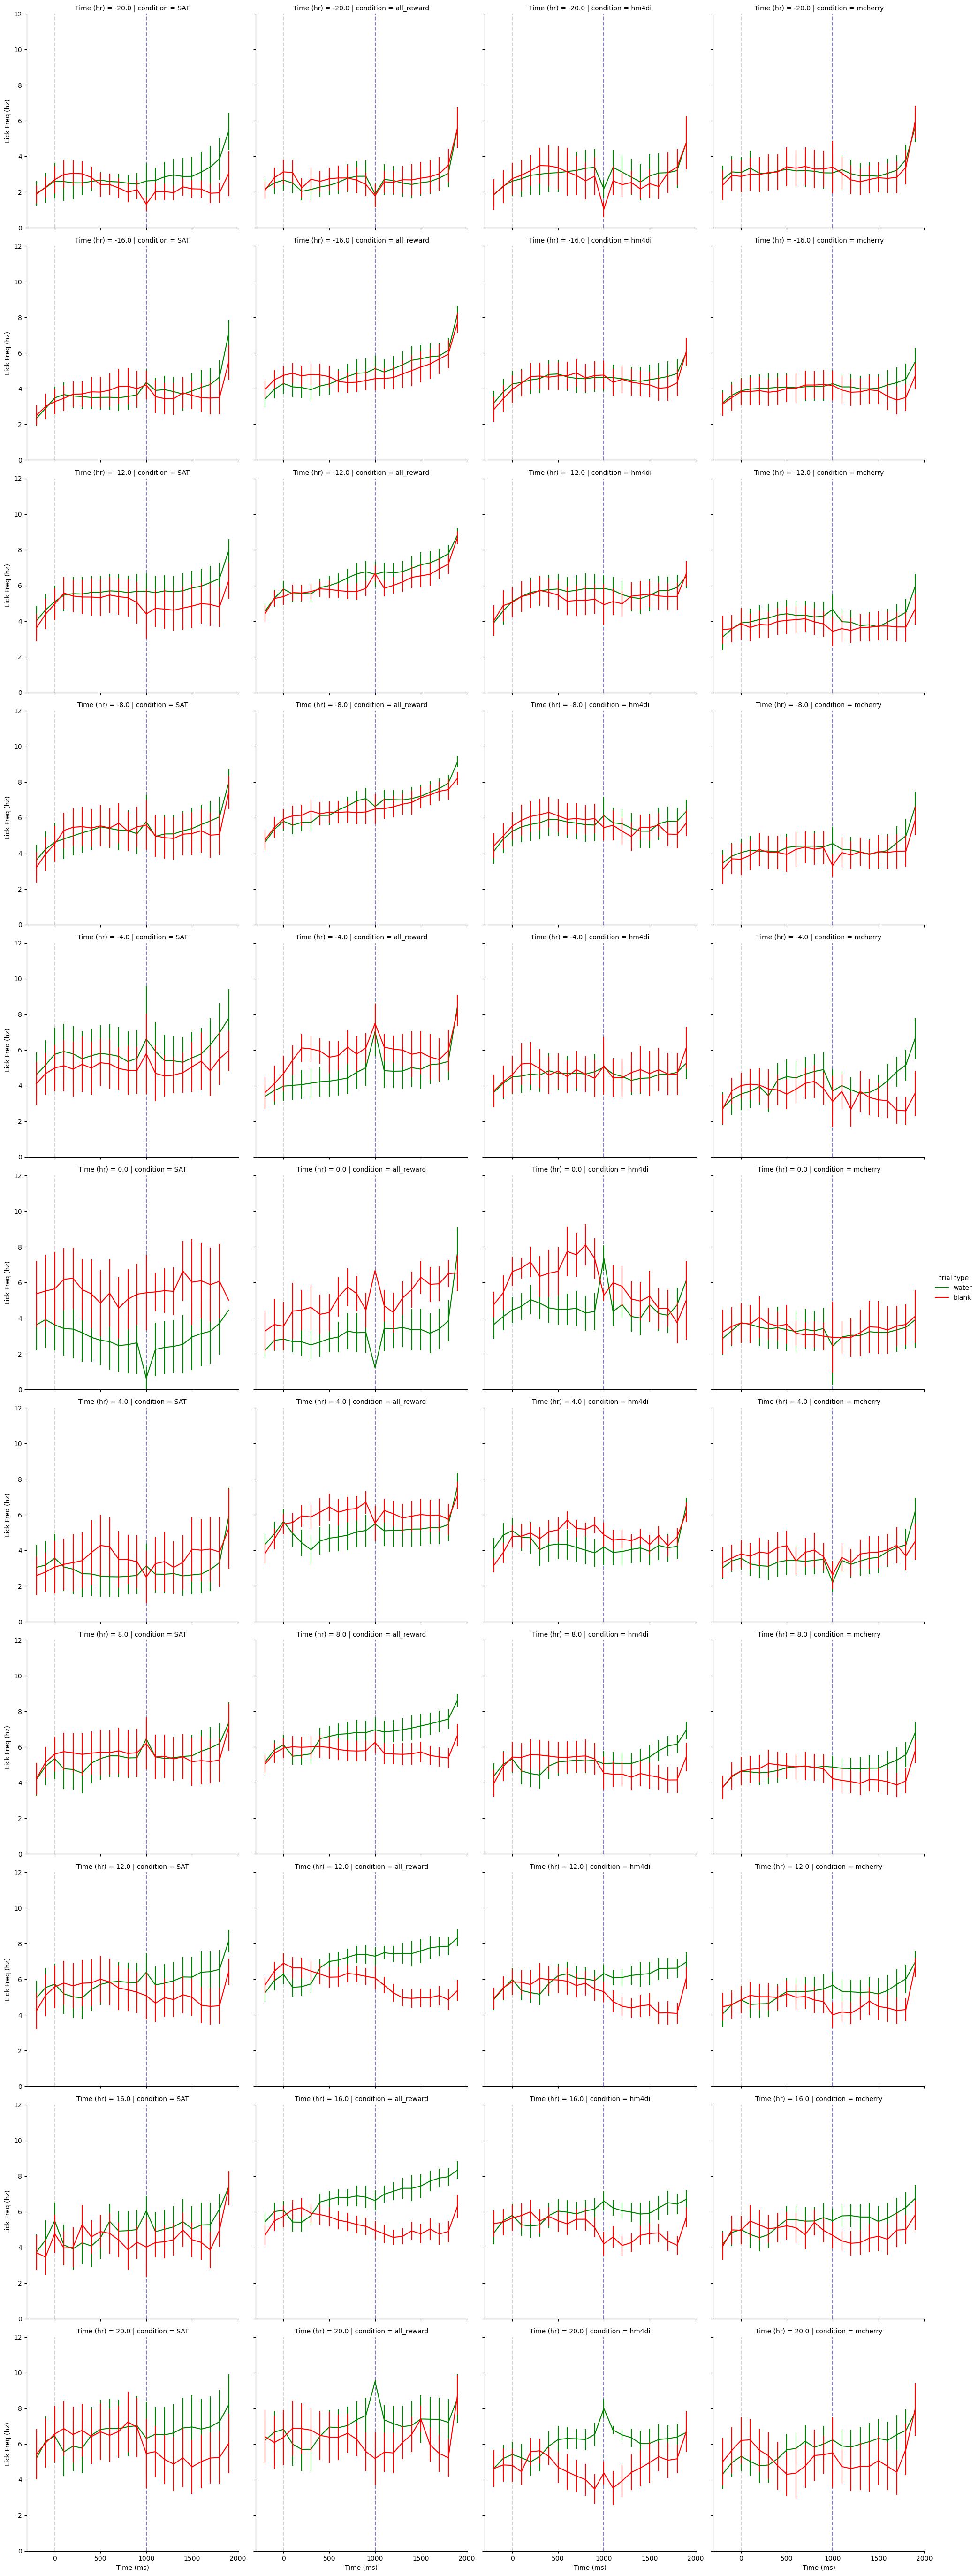

In [158]:
# average lick frequecy trace across all timebins, 4h

# only plot last day of acclimation and first day of SAT
cond = (data_4h["Time (hr)"] < 24) & (data_4h["Time (hr)"] > -24)

# plot all timebins average performance trace on the same plot
g = sns.relplot(data=data_4h[cond],kind="line",x="Time (ms)", y="lick",col="condition", row="Time (hr)",
                hue="trial type", palette=["green", "red"], hue_order=["water", "blank"], errorbar="se",err_style="bars", legend="full")


# add lines at air puff and water delivery
for ax in g.axes.flat:
    ax.axhline(y=0, xmin=0, xmax=1, ls="-", lw=0.75,color="black", zorder=0)
    ax.axvline(x=0, ymin=0, ymax=1, ls="--", color="lightgrey", zorder=0)
    ax.axvline(x=1000, ymin=0, ymax=1, ls="--", color="navy", alpha=0.5, zorder=0)
    ax.set_ylim([0, 12])
    ax.set_ylabel("Lick Freq (hz)")

c:\Users\swind\miniconda3\envs\behavior\Lib\site-packages\matplotlib\axes\_axes.py:1185: RuntimeWarning: All-NaN axis encountered
  miny = np.nanmin(masked_verts[..., 1])
c:\Users\swind\miniconda3\envs\behavior\Lib\site-packages\matplotlib\axes\_axes.py:1186: RuntimeWarning: All-NaN axis encountered
  maxy = np.nanmax(masked_verts[..., 1])
c:\Users\swind\miniconda3\envs\behavior\Lib\site-packages\matplotlib\axes\_axes.py:1185: RuntimeWarning: All-NaN axis encountered
  miny = np.nanmin(masked_verts[..., 1])
c:\Users\swind\miniconda3\envs\behavior\Lib\site-packages\matplotlib\axes\_axes.py:1186: RuntimeWarning: All-NaN axis encountered
  maxy = np.nanmax(masked_verts[..., 1])
c:\Users\swind\miniconda3\envs\behavior\Lib\site-packages\matplotlib\axes\_axes.py:1185: RuntimeWarning: All-NaN axis encountered
  miny = np.nanmin(masked_verts[..., 1])
c:\Users\swind\miniconda3\envs\behavior\Lib\site-packages\matplotlib\axes\_axes.py:1186: RuntimeWarning: All-NaN axis encountered
  maxy = np.nan

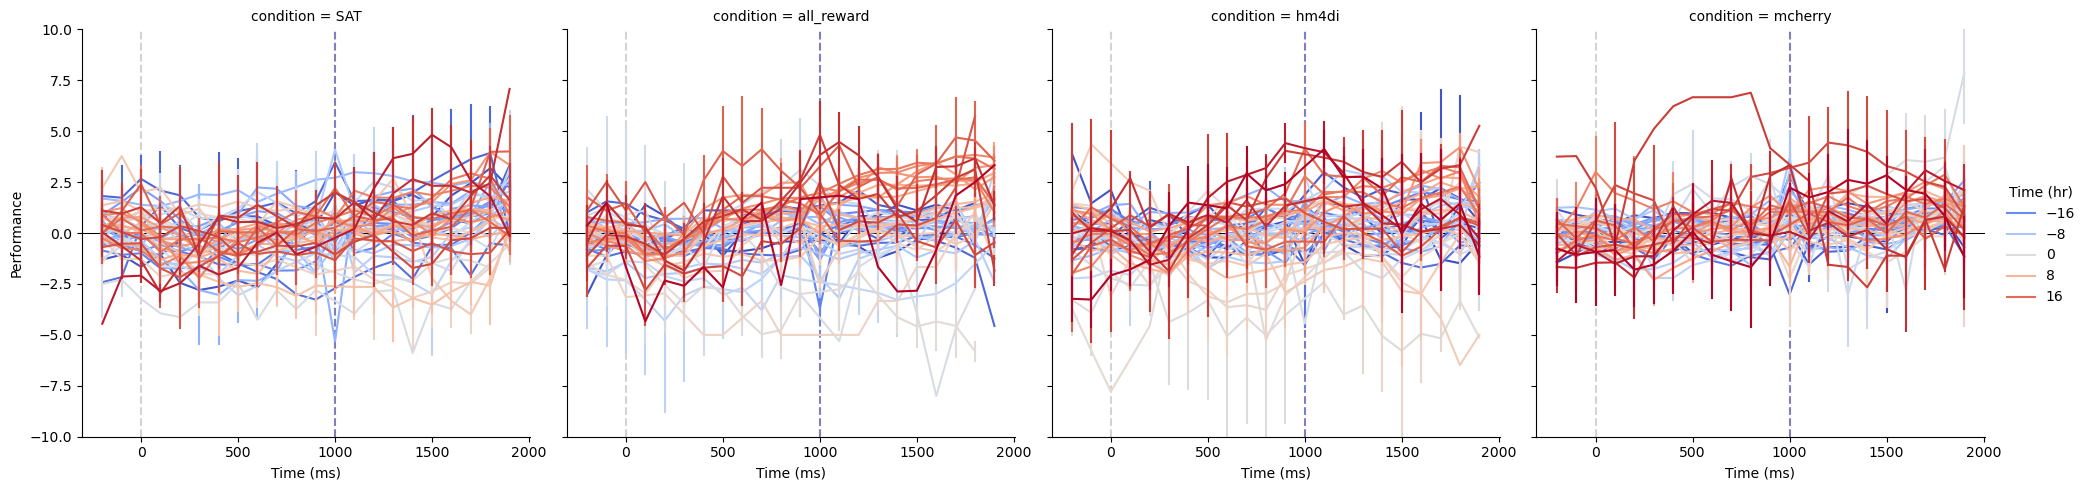

In [121]:
# average performance trace across all timebins, 1h

# only plot last day of acclimation and first day of SAT
cond = (perf_1h["Time (hr)"] < 24) & (perf_1h["Time (hr)"] > -24)

# plot all timebins average performance trace on the same plot
g = sns.relplot(data=perf_1h[cond],kind="line",x="Time (ms)", y="lick",col="condition", 
                hue="Time (hr)", palette="coolwarm", errorbar="se",err_style="bars", legend="brief")

# add lines at air puff and water delivery
for ax in g.axes.flat:
    ax.axhline(y=0, xmin=0, xmax=1, ls="-", lw=0.75,color="black", zorder=0)
    ax.axvline(x=0, ymin=0, ymax=1, ls="--", color="lightgrey", zorder=0)
    ax.axvline(x=1000, ymin=0, ymax=1, ls="--", color="navy", alpha=0.5, zorder=0)
    ax.set_ylim([-10, 10])
    ax.set_ylabel("Performance")

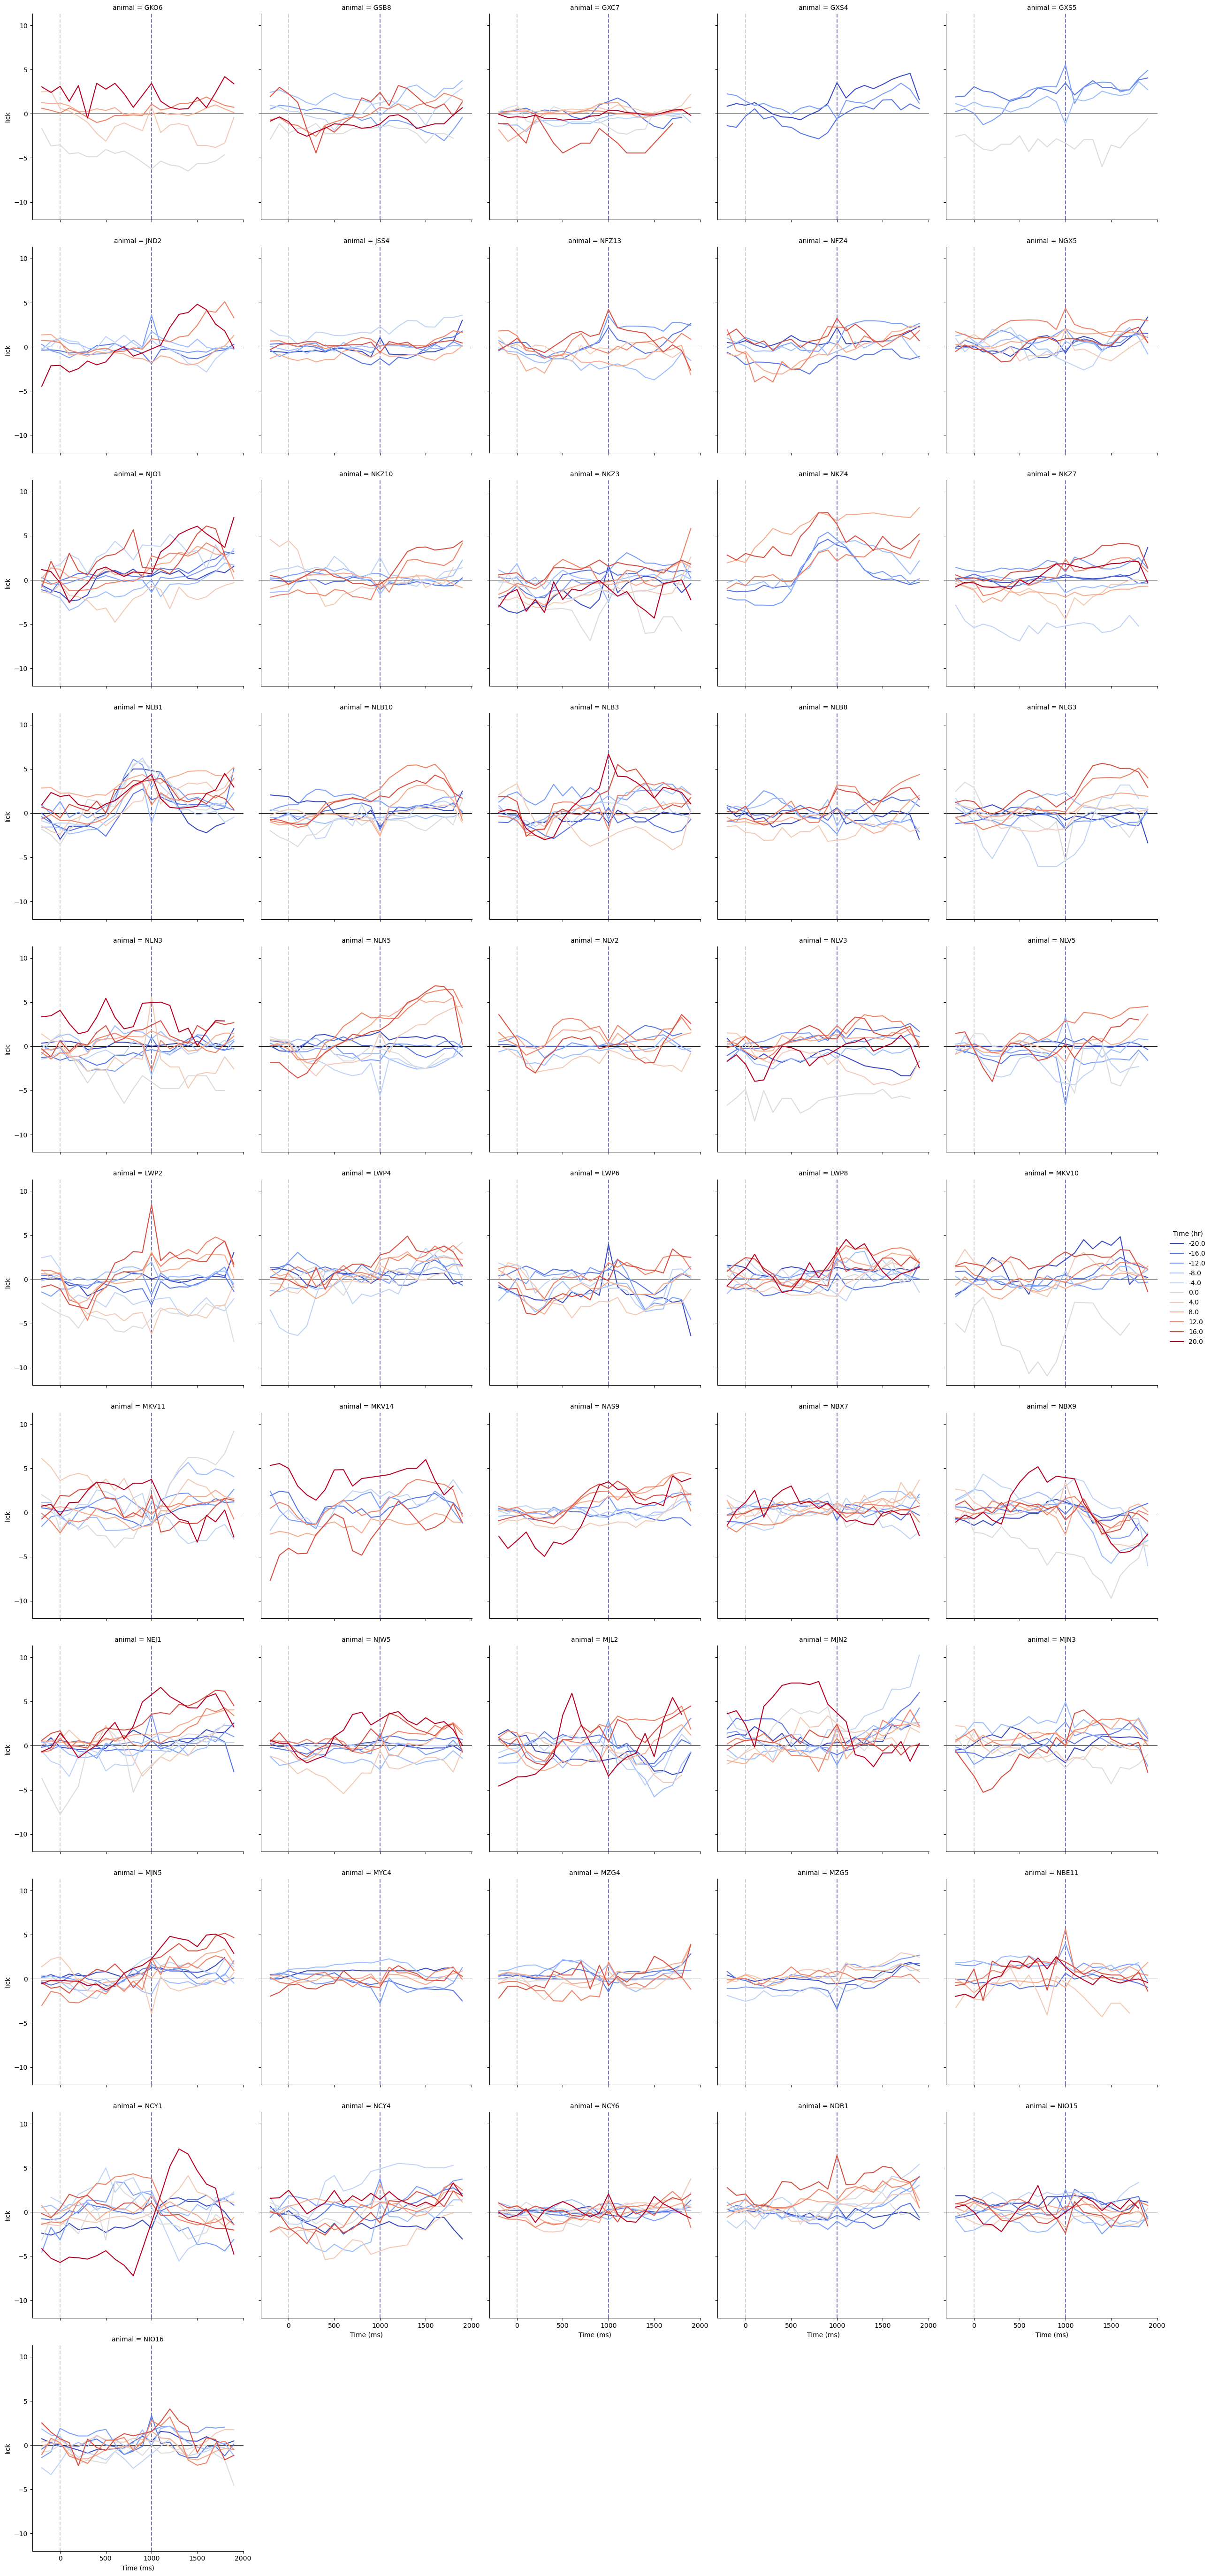

In [122]:
# average performance trace by animal, 4h timebins
cond = (perf_4h["Time (hr)"] < 24) & (perf_4h["Time (hr)"] > -24) 
g = sns.relplot(data=perf_4h[cond],kind="line",x="Time (ms)", 
                y="lick",col="animal", col_wrap=5,hue="Time (hr)", palette="coolwarm", errorbar=None,legend="full")
for ax in g.axes.flat:
    ax.axhline(y=0, xmin=0, xmax=1, ls="-", lw=0.75,color="black", zorder=0)
    ax.axvline(x=0, ymin=0, ymax=1, ls="--", color="lightgrey", zorder=0)
    ax.axvline(x=1000, ymin=0, ymax=1, ls="--", color="navy", alpha=0.5, zorder=0)

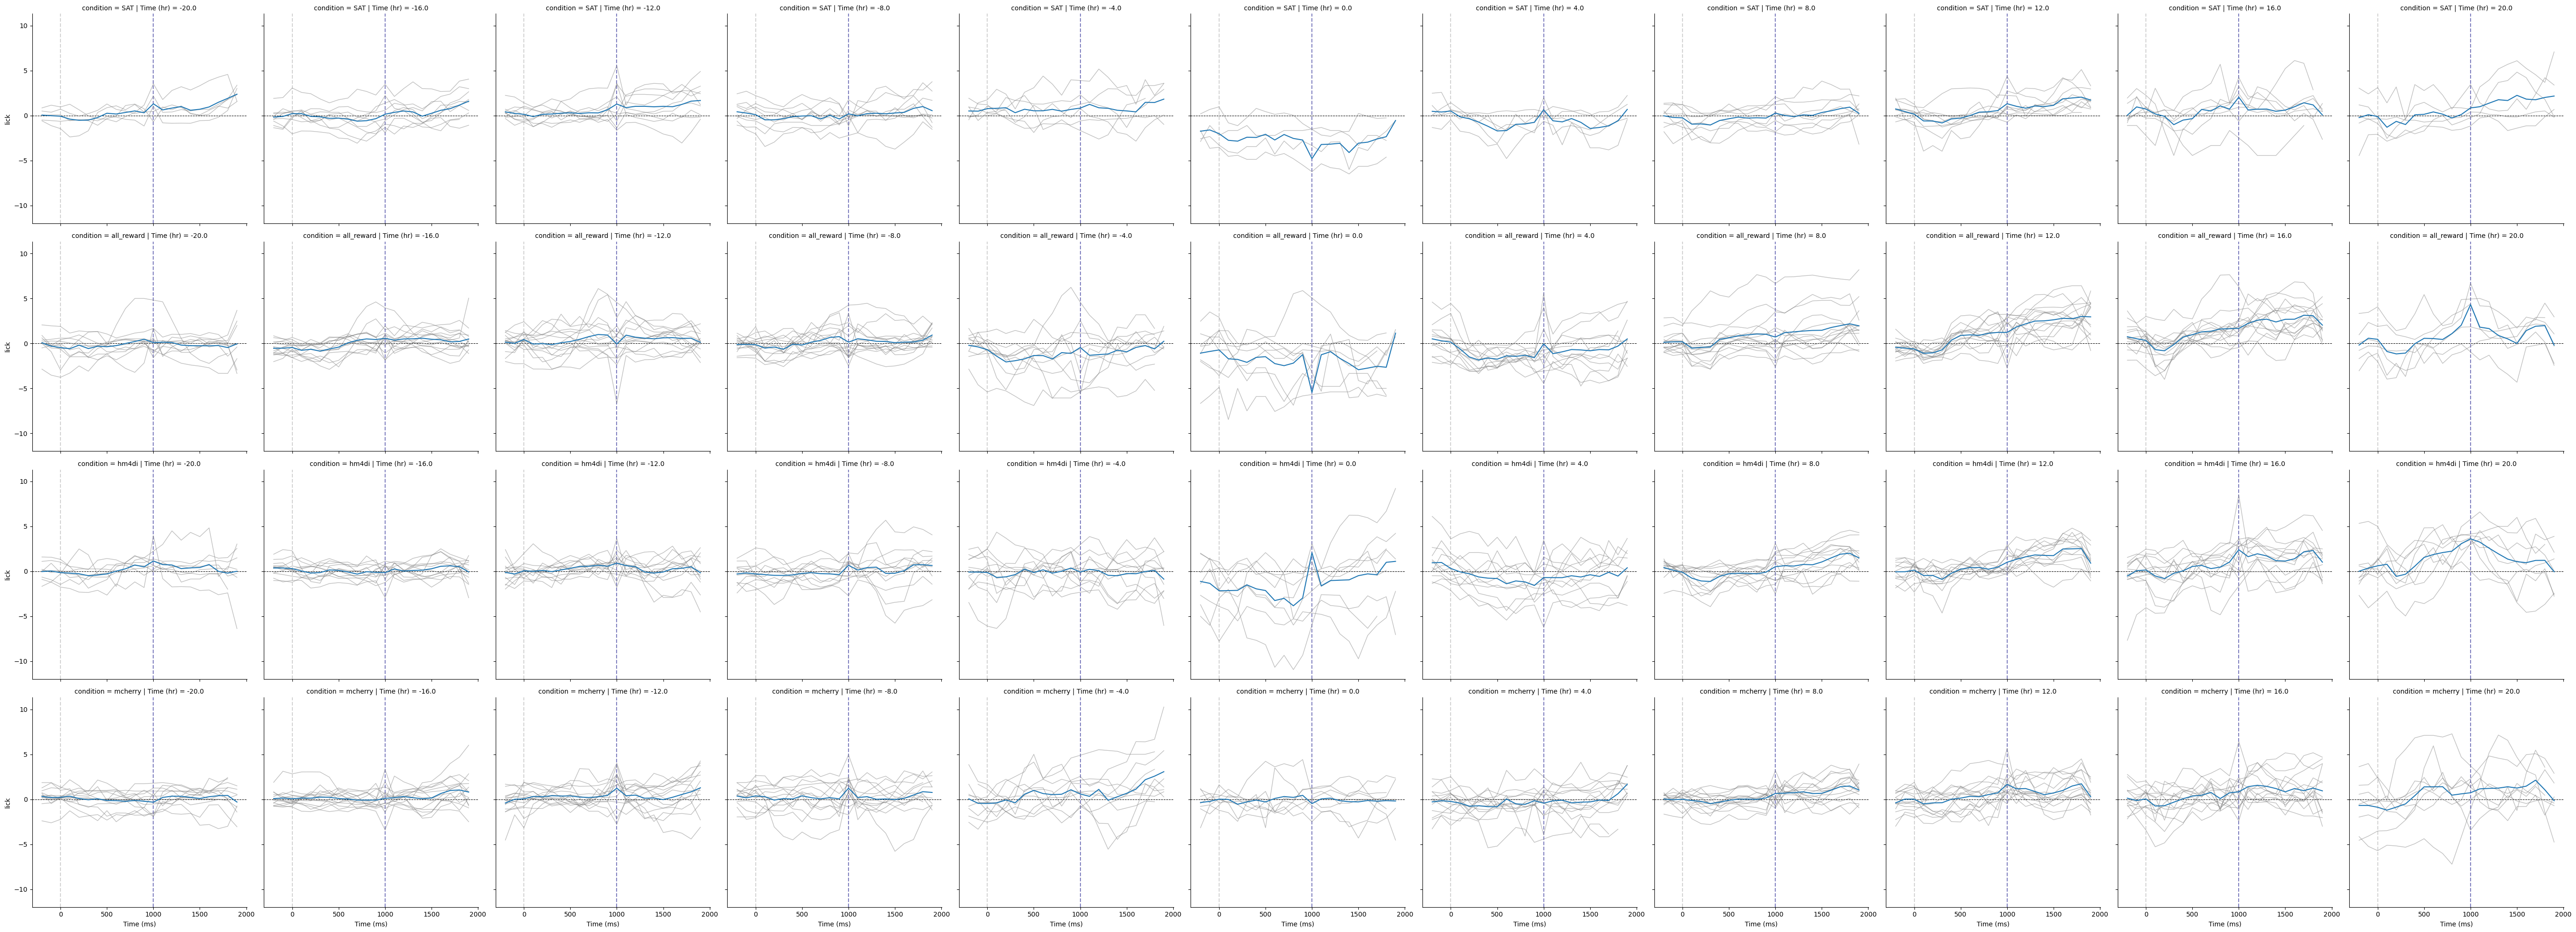

In [123]:
# average performance trace by timebin, 4h timebins, with each animals' performance in the background

cond = (perf_4h["Time (hr)"] < 24) & (perf_4h["Time (hr)"] > -24) 
g = sns.relplot(data=perf_4h[cond],kind="line",x="Time (ms)", 
                y="lick",col="Time (hr)", row="condition", errorbar=None, zorder=5)
for (train_type, time), ax in g.axes_dict.items():
    an_cond = perf_4h["condition"] == train_type
    time_cond = perf_4h["Time (hr)"] == time
    sns.lineplot(
            data=perf_4h[cond & an_cond & time_cond], x="Time (ms)", y="lick", hue="animal", 
            palette=["grey"], alpha=0.5,linewidth=1, ax=ax, legend=False)
    ax.axhline(y=0, xmin=0, xmax=1, ls="--", lw=0.75,color="black", zorder=0)
    ax.axvline(x=0, ymin=0, ymax=1, ls="--", color="lightgrey", zorder=0)
    ax.axvline(x=1000, ymin=0, ymax=1, ls="--", color="navy", alpha=0.5, zorder=0)

In [124]:
# average performance by timebin across all animals
index = ["condition", "delta", "delivery delta"]
keep = ["age", "sex", "strain", "Time (hr)", "Time (ms)"]

gp = perf_4h.groupby(index)
perf_avg = gp["lick"].mean()
keep = gp[keep].first()
perf_avg = pd.concat([perf_avg, keep], axis=1).reset_index()

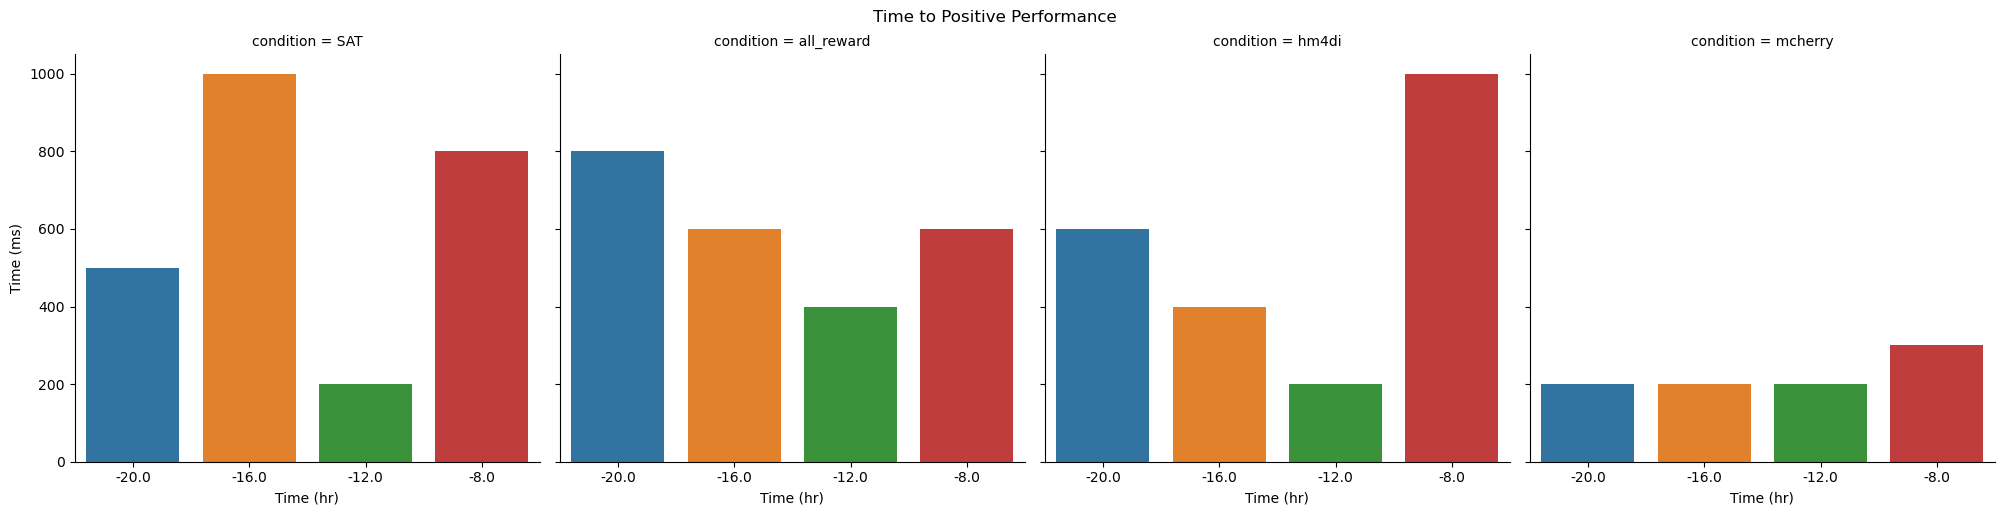

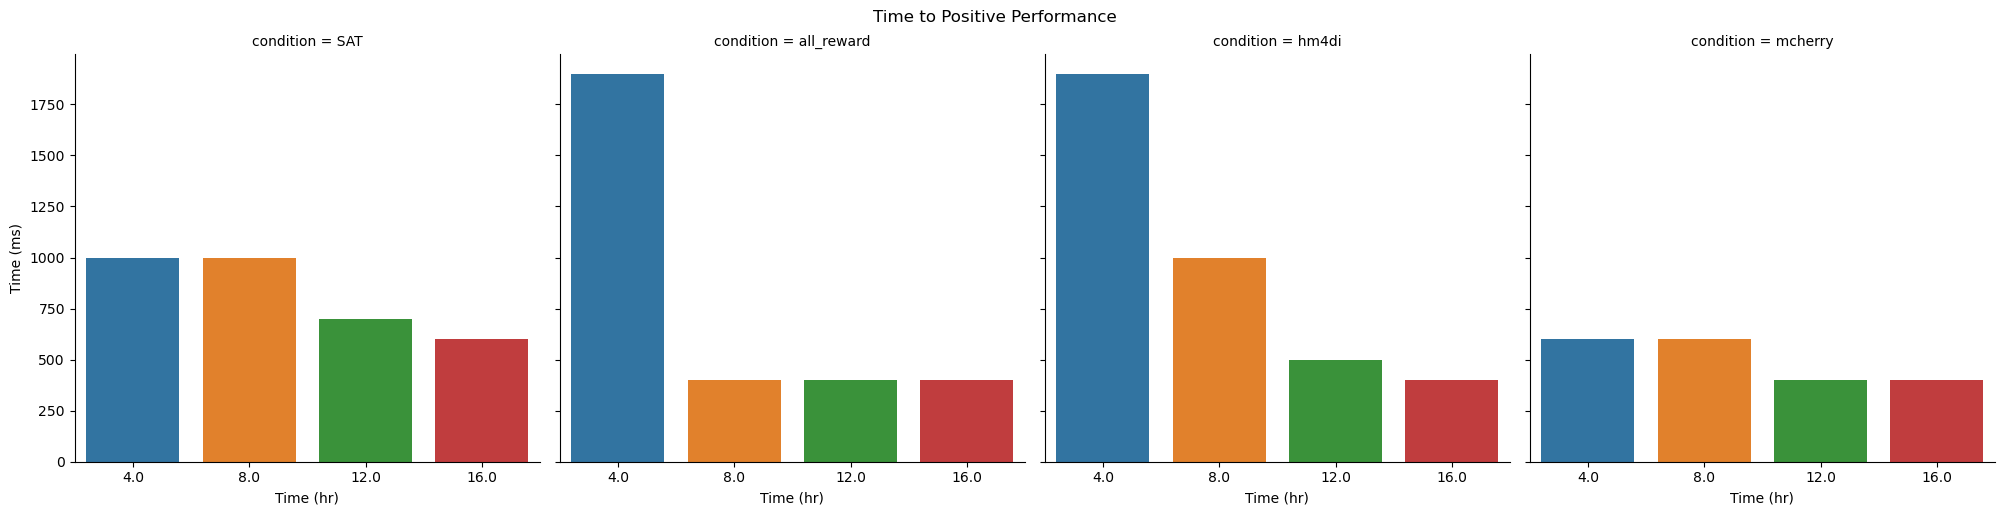

In [125]:
# average time until performance becomes positive from start of air for each timebin

cond = (perf_avg["lick"] > 0) & (perf_avg["Time (ms)"] > 100)
pt = perf_avg[cond].groupby(["condition", "delta"]).first().reset_index()

cond = (pt["Time (hr)"] < -4) & (pt["Time (hr)"] > -24)
g = sns.catplot(data=pt[cond], kind="bar", x="Time (hr)", y="Time (ms)", col="condition", col_wrap=5)
g.fig.suptitle("Time to Positive Performance", x=0.4, y=1.02)
g.set_xlabels("Time (hr)")
g.set_ylabels("Time (ms)")    

cond = (pt["Time (hr)"] < 20) & (pt["Time (hr)"] > 0)
g = sns.catplot(data=pt[cond], kind="bar", x="Time (hr)", y="Time (ms)", col="condition", col_wrap=5)
g.fig.suptitle("Time to Positive Performance", x=0.4, y=1.02)
g.set_xlabels("Time (hr)")
g.set_ylabels("Time (ms)")    

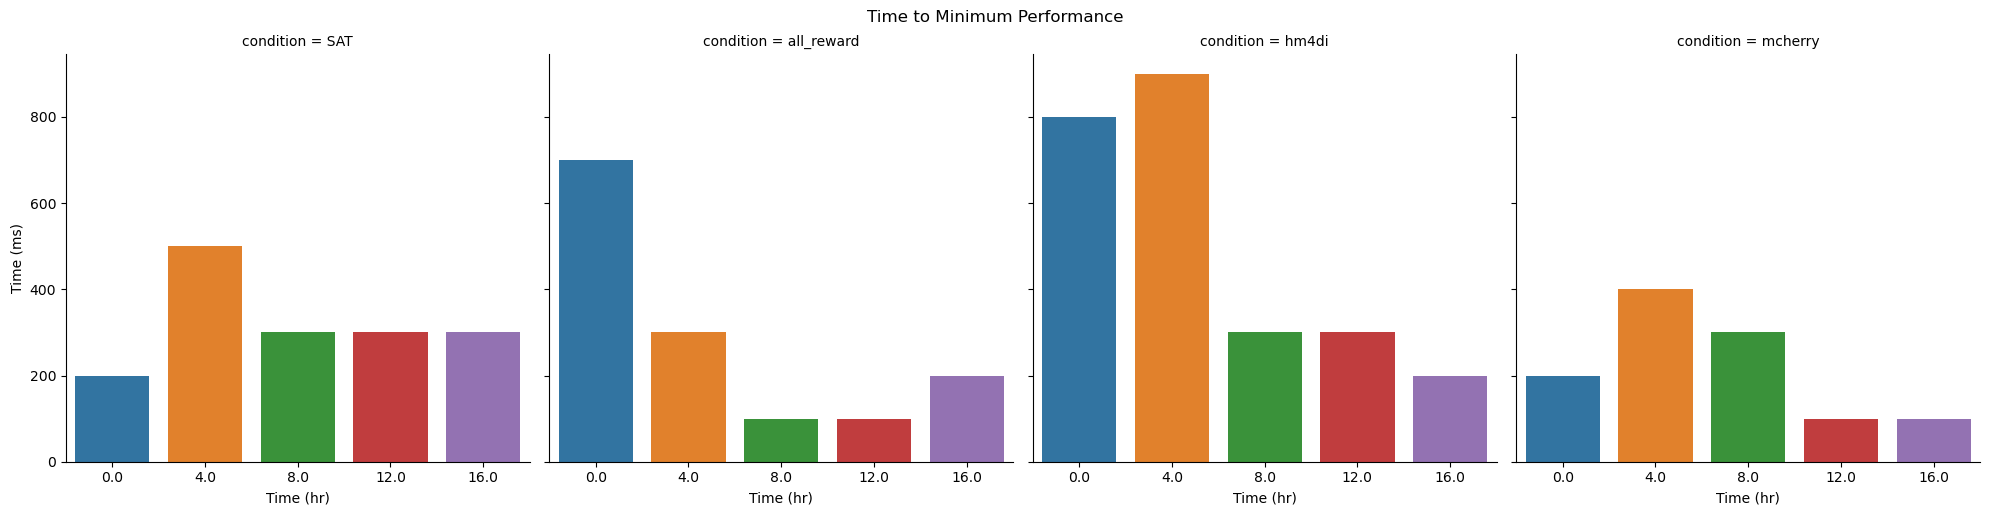

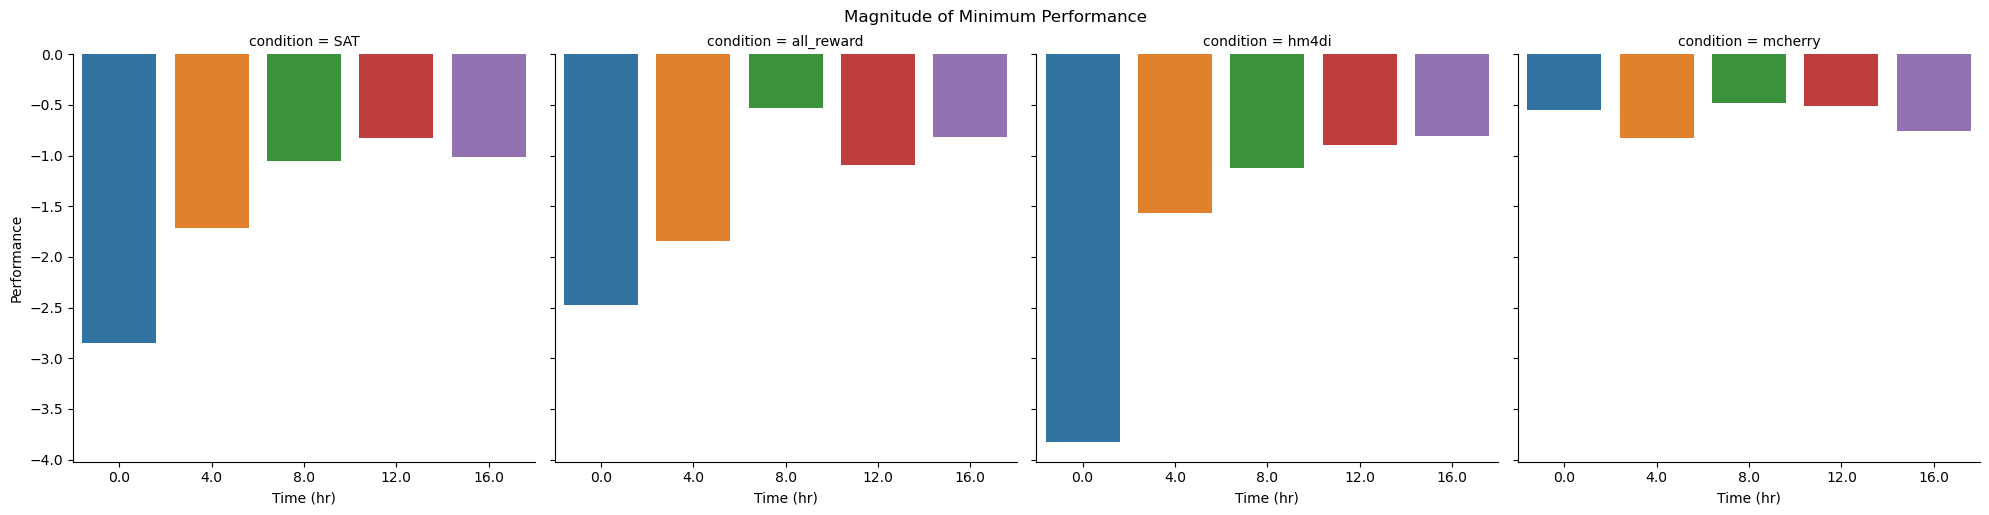

In [151]:
cond = (perf_avg["Time (hr)"] < 20) & (perf_avg["Time (hr)"] >= 0) & (perf_avg["Time (ms)"] > 0) & (perf_avg["Time (ms)"] < 1000)
pt_puff = perf_avg[cond].sort_values("lick").groupby(["condition", "delta"]).first().reset_index()

g = sns.catplot(data=pt_puff, kind="bar", x="Time (hr)", y="Time (ms)", col="condition")
g.fig.suptitle("Time to Minimum Performance", x=0.5, y=1.02)
g.set_xlabels("Time (hr)")
g.set_ylabels("Time (ms)")    

g = sns.catplot(data=pt_puff, kind="bar", x="Time (hr)", y="lick", col="condition")
g.fig.suptitle("Magnitude of Minimum Performance", x=0.5, y=1.02)
g.set_xlabels("Time (hr)")
g.set_ylabels("Performance")  

In [127]:
# average licking frequency by timebin across all animals
index = ["condition", "delta", "delivery delta", "trial type"]
keep = ["age", "sex", "strain", "Time (hr)", "Time (ms)"]

gp = data_4h.groupby(index)
lick_avg = gp["lick"].mean()
keep = gp[keep].first()
lick_avg = pd.concat([lick_avg, keep], axis=1).reset_index()

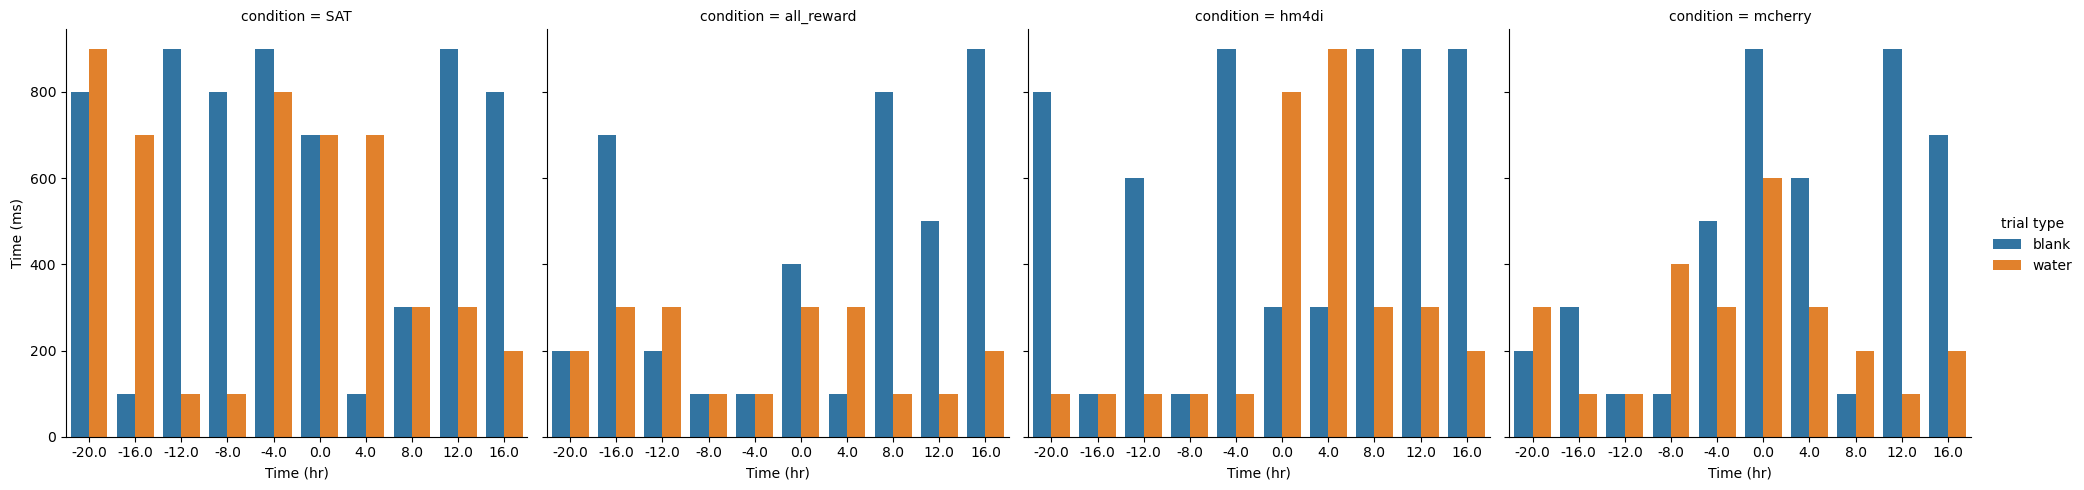

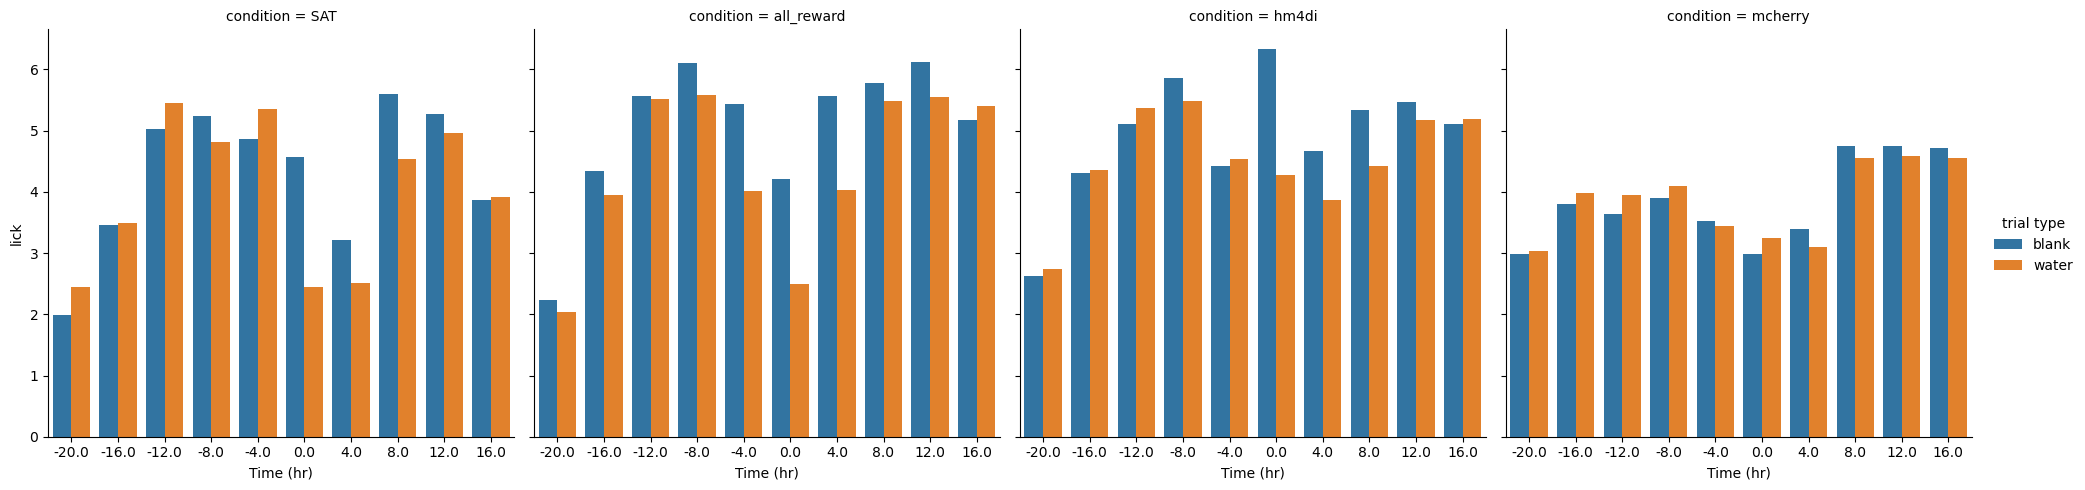

In [128]:
# time to postive performance and magniutude of maximum licking frequency by trial type and timebin
cond = (lick_avg["Time (hr)"] < 20) & (lick_avg["Time (hr)"] > -24) & (lick_avg["Time (ms)"] > 0) & (lick_avg["Time (ms)"] < 1000)
pt_puff = lick_avg[cond].sort_values("lick").groupby(["condition", "delta", "trial type"]).first().reset_index()

sns.catplot(data=pt_puff, kind="bar", x="Time (hr)", y="Time (ms)", col="condition",  hue="trial type")
sns.catplot(data=pt_puff, kind="bar", x="Time (hr)", y="lick", col="condition", hue="trial type")